In [1]:
import requests as r
from bs4 import BeautifulSoup

### Getting translations from wiki-data based on ids and desired translations

In [10]:
import json

'''Simple function for getting json (not really needed anymore)'''
def get_json(wiki_id):
    req = r.get(f'https://www.wikidata.org/wiki/Special:EntityData/{wiki_id}.json')

    j = json.loads(req.text)

    return j


'''Take in a wiki id, and an optional list of desired translations(must match language names)
    return a dictionary containing translations
    if no desired translations are passed returns all translations
'''
def get_translations_from_id(wiki_id:str, desired_translations: list = None):
        req = r.get(f'https://www.wikidata.org/wiki/Special:EntityData/{wiki_id}.json')

        j = json.loads(req.text)

        if desired_translations:
            out_ = {}
            for translation in desired_translations:
                try:
                    out_[translation] = j['entities'][wiki_id]['labels'][translation]
                except:
                    print(f"Encountered error retrieving {translation}")
        else:
            return j['entities'][wiki_id]['labels']


        return out_ 
            


In [11]:
#getting specific translations 
es = get_translations_from_id("Q110246392", ['fr', 'de', 'th'])
es

{'fr': {'language': 'fr', 'value': 'Little Women'},
 'de': {'language': 'de', 'value': 'Little Women'},
 'th': {'language': 'th', 'value': 'สามพี่น้อง'}}

In [51]:
#getting all translations
all_of_em = get_translations_from_id("Q110246392")
all_of_em

{'en': {'language': 'en', 'value': 'Little Women'},
 'ar': {'language': 'ar', 'value': 'نساء صغيرات'},
 'id': {'language': 'id', 'value': 'Little Women'},
 'ko': {'language': 'ko', 'value': '작은 아씨들'},
 'es': {'language': 'es', 'value': 'Las hermanas'},
 'zh': {'language': 'zh', 'value': '小女子'},
 'vi': {'language': 'vi', 'value': 'Little Women'},
 'ja': {'language': 'ja', 'value': '新・若草物語'},
 'fa': {'language': 'fa', 'value': 'زنان کوچک'},
 'ms': {'language': 'ms', 'value': 'Little Women'},
 'ru': {'language': 'ru', 'value': 'Маленькие женщины'},
 'zh-tw': {'language': 'zh-tw', 'value': '小女子'},
 'fr': {'language': 'fr', 'value': 'Little Women'},
 'de': {'language': 'de', 'value': 'Little Women'},
 'th': {'language': 'th', 'value': 'สามพี่น้อง'},
 'uz': {'language': 'uz', 'value': 'Little Women'},
 'it': {'language': 'it', 'value': 'Piccole donne'},
 'zh-hans': {'language': 'zh-hans', 'value': '小女子'}}

### Query for multiple items at once

> this does not save resources only makes it easier on our end
> Potentially want to look into a better way to reduce requests sent to wikidata

In [41]:
'''Function to query for multiple wiki-id translations at once'''
def aggregate_multiple(wiki_ids: list[str], translations: list[str]=None):
    out_ = {}
    for wiki_id in wiki_ids:
        try:
            t_out_ = get_translations_from_id(wiki_id, translations)
            out_[wiki_id] = t_out_
        except Exception as e:
            print(f"Unable to get translations for {wiki_id}\n{e}")

    return out_


In [45]:
t = aggregate_multiple(["Q110246392", "Q910656", "Q733195"], ['it', 'fr', 'ru', 'ja'])
t

Encountered error retrieving ru


{'Q110246392': {'it': {'language': 'it', 'value': 'Piccole donne'},
  'fr': {'language': 'fr', 'value': 'Little Women'},
  'ru': {'language': 'ru', 'value': 'Маленькие женщины'},
  'ja': {'language': 'ja', 'value': '新・若草物語'}},
 'Q910656': {'it': {'language': 'it', 'value': 'olio di neem'},
  'fr': {'language': 'fr', 'value': 'Huile de neem'},
  'ja': {'language': 'ja', 'value': 'ニームオイル'}},
 'Q733195': {'it': {'language': 'it', 'value': 'Repubblica Galattica'},
  'fr': {'language': 'fr', 'value': 'République galactique'},
  'ru': {'language': 'ru', 'value': 'Галактическая Республика'},
  'ja': {'language': 'ja', 'value': '銀河共和国'}}}

In [38]:
t

### Getting Ids from string queries

> will return first result if it finds it as the answer (not neccisarily true)

In [66]:
# Now need to find a good way to query / find the ids from a name
#  (ID is also provided via training data but it might not hurt to have this feature)
from bs4 import BeautifulSoup
import urllib.parse

'''Function to attempt to get a wiki id from a string name (throws exceptions if unable to find a first result)
    Naively returns the first result as the "interpreted" 
'''
def query_for_id(name: str):
    encoded = urllib.parse.urlencode({"search": name})
    req = r.get(f'https://www.wikidata.org/w/index.php?{encoded}')

    

    try:
        soup = BeautifulSoup(req.text, 'html.parser')
        result = soup.find('div', class_="mw-search-result-heading")
        link = result.find('a')
        return link['href'].split("/")[2]
        
    except Exception as e:
        print(f"Encountered : {e}\n\t when querying for {name}")

In [12]:
query_for_id("Galactic Republic")

NameError: name 'query_for_id' is not defined

In [50]:
from tqdm import tqdm

def get_instance_of(wiki_id:str):
    req = r.get(f'https://www.wikidata.org/wiki/{wiki_id}')
    soup = BeautifulSoup(req.text)
    title = soup.find('span', class_='wikibase-title-label')
    d = soup.find('div', class_="wikibase-snakview-value wikibase-snakview-variation-valuesnak")
    a = d.find('a')
    
    return (title.text, a.text)

def collect_instances(ids:list[str]):
    instances = []
    for id in tqdm(ids, desc="Scraping info"):
        iof = get_instance_of(id)
        instances.append(iof)
    
    return instances


In [22]:
get_instance_of('Q56881140')

200
film


In [51]:
import pandas as pd
import os 

total_instances = []
for lang in os.listdir('../sample'):
    joi = pd.read_json(f'../sample/{lang}', lines=True)
    joi['wiki_id'] = joi['metadata'].apply(lambda x: x['wikidata_id'])
    ids = joi['wiki_id'].tolist()
    instances = collect_instances(ids)

    total_instances += instances

print(total_instances)


Scraping info: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

[('The Invisible Man', 'literary work'), ('Mulheres Apaixonadas', 'television series'), ('Sefirin Kızı', 'television series'), ("Don't F**k with Cats: Hunting an Internet Killer", 'television series'), ('Symphony No. 9', 'musical work/composition'), ('Discourse on the Method', 'written work'), ('The Three Musketeers', 'literary work'), ("St. Basil's Cathedral", 'Eastern Orthodox church building'), ('Planet of the Apes', 'literary work'), ('The Turk', 'appliance'), ('Berlin Cathedral', 'lutheran church'), ('President of Russia', 'state position of the Russian Federation'), ('Anatoly Dyatlov', 'human'), ('Cavern of the Patriarchs', 'mosque'), ('Galactic Empire', 'galactic empire'), ("Prophet's Mosque", 'congregational mosque'), ('A City of Sadness', 'film'), ('Alexei Nikolaevich, Tsarevich of Russia', 'human'), ('Simpson family', 'fictional family'), ('rose hip', 'pome'), ('The Firebird', 'ballet'), ("Prophet's Mosque", 'congregational mosque'), ('Planet of the Apes', 'literary work'), (

In [52]:
ts = pd.DataFrame(total_instances,columns=['ent_name', 'instance_of'])

In [54]:
ts.head()
ts.to_csv('name_instance_of.csv')

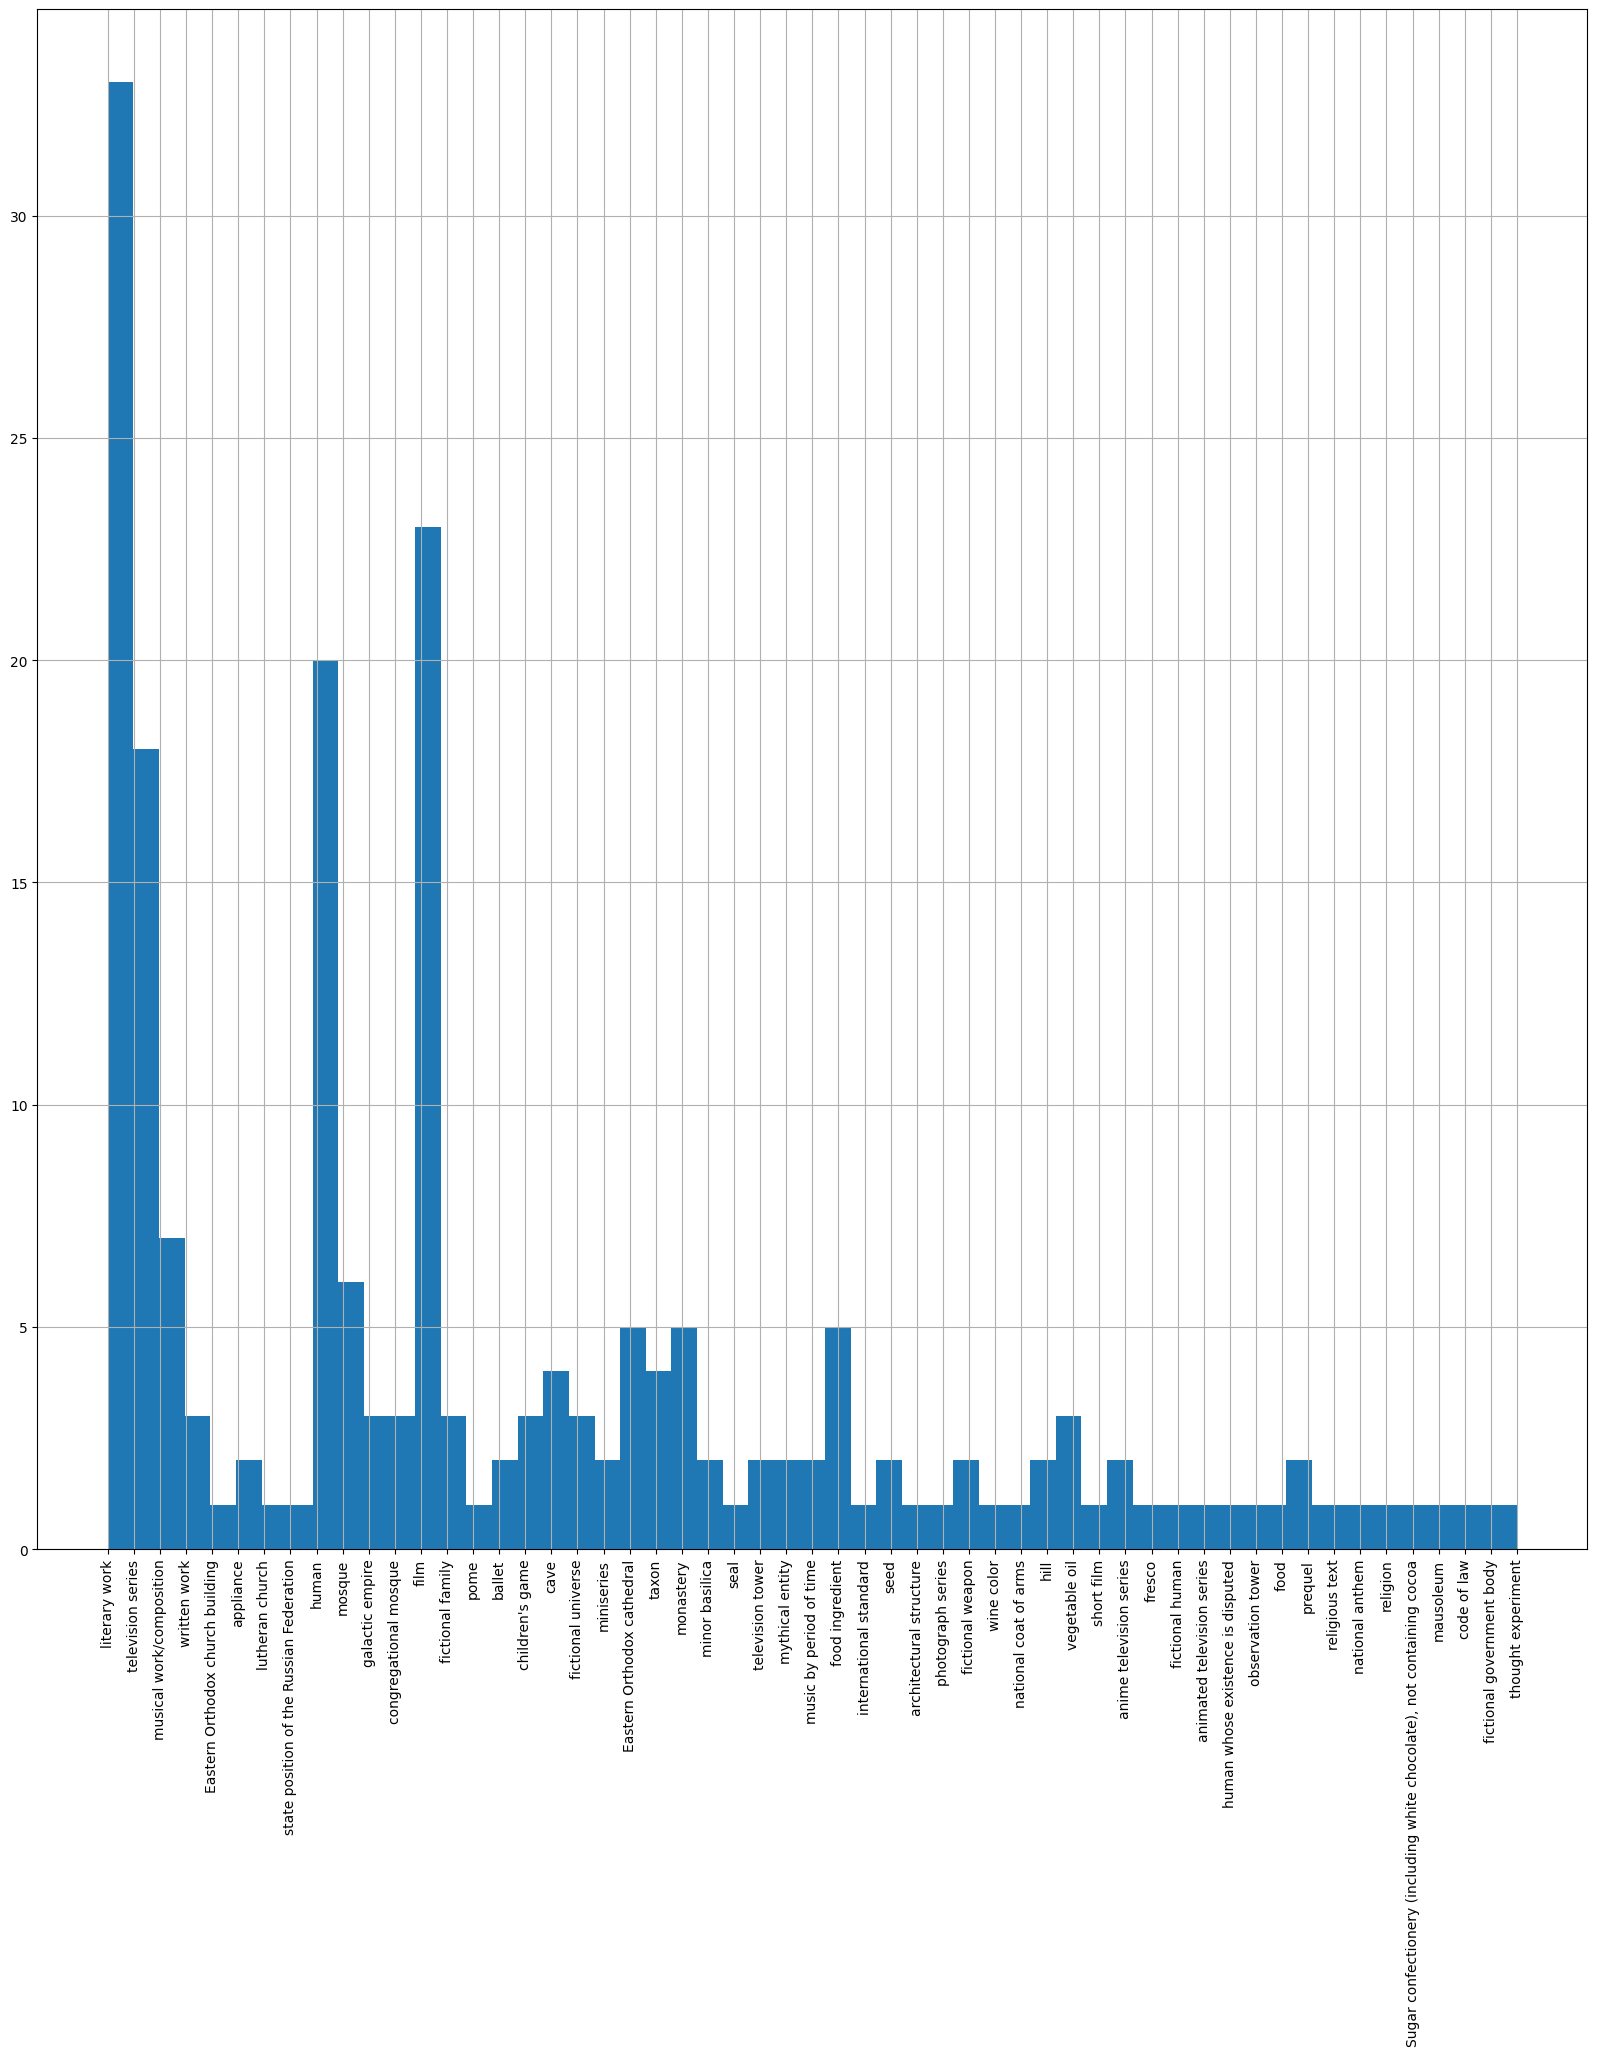

In [57]:
import collections
ts['instance_of'].hist(xrot=90, figsize=(20,20),bins=len(ts['instance_of'].unique()))

a = collections.Counter(ts['instance_of'])

In [69]:
a.most_common(5)

[('literary work', 33),
 ('film', 23),
 ('human', 20),
 ('television series', 18),
 ('musical work/composition', 7)]

In [72]:
a.most_common(50)

[('literary work', 33),
 ('film', 23),
 ('human', 20),
 ('television series', 18),
 ('musical work/composition', 7),
 ('mosque', 6),
 ('Eastern Orthodox cathedral', 5),
 ('monastery', 5),
 ('food ingredient', 5),
 ('cave', 4),
 ('taxon', 4),
 ('written work', 3),
 ('galactic empire', 3),
 ('congregational mosque', 3),
 ('fictional family', 3),
 ("children's game", 3),
 ('fictional universe', 3),
 ('vegetable oil', 3),
 ('appliance', 2),
 ('ballet', 2),
 ('miniseries', 2),
 ('minor basilica', 2),
 ('television tower', 2),
 ('mythical entity', 2),
 ('music by period of time', 2),
 ('seed', 2),
 ('fictional weapon', 2),
 ('hill', 2),
 ('anime television series', 2),
 ('prequel', 2),
 ('Eastern Orthodox church building', 1),
 ('lutheran church', 1),
 ('state position of the Russian Federation', 1),
 ('pome', 1),
 ('seal', 1),
 ('international standard', 1),
 ('architectural structure', 1),
 ('photograph series', 1),
 ('wine color', 1),
 ('national coat of arms', 1),
 ('short film', 1),
 ('

In [65]:
len(ts['ent_name'].unique())

122

In [66]:
len(ts['instance_of'].unique())

55

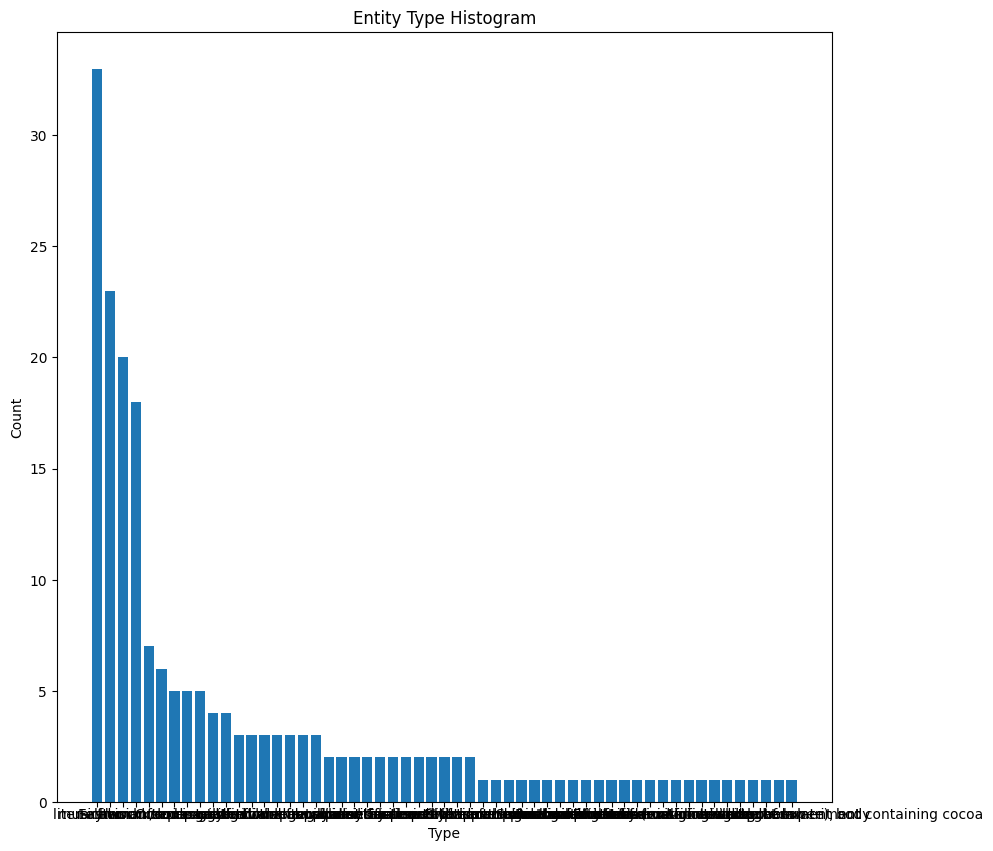

In [81]:
import matplotlib.pyplot as plt

categories = list(a.keys())
counts = list(a.values())



fig, ax = plt.subplots(1,1, figsize=(10,10))

# Create a histogram (bar plot)
x = []
y = []
for n,c in a.most_common():
    x.append(n)
    y.append(c)
ax.bar(x,y)


# Add labels and title
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.tick_params('x', pad=0.5)

plt.title('Entity Type Histogram')

# Show the plot
plt.show()

In [84]:
# Convert Counter to DataFrame
df = pd.DataFrame(a.most_common(), columns=['Entity', 'Count'])

# Display styled DataFrame
df.style.set_caption("Counter Table").set_table_styles(
    [{'selector': 'caption', 'props': 'caption-side: top; font-weight: bold; font-size: 14px;'}]
)

,Entity,Count
0,literary work,33
1,film,23
2,human,20
3,television series,18
4,musical work/composition,7
5,mosque,6
6,Eastern Orthodox cathedral,5
7,monastery,5
8,food ingredient,5
9,cave,4


In [99]:
ts[ts['instance_of']=='religion']

,ent_name,instance_of
161,LaVeyan Satanism,religion


In [97]:
1/a.total()

0.005